In [1]:
# !pip install plotly

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import plotly.express as px

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random
import seaborn as sns
import statsmodels.api as sm



from random import choices
from scipy import stats
from tqdm.notebook import tqdm
from matplotlib.colors import ListedColormap

In [6]:
from jupyter_utils import style, mean_std, display_test, display_group_test, \
    scatter_annotate, show_corrtest_mask_corr, pointplot, pointplot_horizontal, add_grey, \
    prep_horizontal_pointplot_errobar_data, map_model, prep_LM_pointplot, draw_sample_with_replacement, t_test
from ortogonolize_utils import draw_scatter, draw_corrected_scatter
from ortogonolize_utils import compute_coefficient, compute_ortogonolized_coefficient, compute_ortogonolized_logit

In [7]:
import warnings
warnings.filterwarnings(action='ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')
warnings.filterwarnings(action='ignore', message='Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.')
warnings.filterwarnings(action='ignore', message='Mean of empty slice')
warnings.filterwarnings(action='ignore', category=stats.ConstantInputWarning)

In [8]:
sns.set_theme(style="whitegrid")

In [9]:
PATH = '/Users/galina.ryazanskaya/Downloads/thesis?/code?/transcripts_NET/'

In [10]:
PATH_FIG = '/Users/galina.ryazanskaya/Downloads/thesis?/figures/de/'

# Patients

In [11]:
df = pd.read_excel(PATH +'NAP/GR_all6M_MPP.xlsx', index_col=0, na_values=[' ', '', -99.0])
df = df[df.index.notnull()].drop(columns=['Unnamed: 98', 'Unnamed: 99'])

total positve ftd - saps34 <br>
total alogia - sans12 <br>
sex_nr - female = 1, male = 0 <br>
ausja_bl = education years at baseline (i.e. 6 months before the NET interview) <br>
pa - panss <br>

In [12]:
# df.columns

In [13]:
# print(*enumerate('PANSS P1	PANSS P2	PANSS P3	PANSS P4	PANSS P5	PANSS P6	PANSS P7	PANSS N1	PANSS N2	PANSS N3	PANSS N4	PANSS N5	PANSS N6	PANSS N7	PANSS O1	PANSS O2	PANSS O3	PANSS O4	PANSS O5	PANSS O6	PANSS O7	PANSS O8	PANSS 09	PANSS O10	PANSS O11	PANSS O12	PANSS O13	PANSS O14	PANSS O15	PANSS 016'.split('\t')))

In [14]:
df['panss_pos'] = df[['pa_01', 'pa_02', 'pa_03', 'pa_04', 'pa_05', 'pa_06', 'pa_07']].sum(axis=1)
df['panss_neg'] = df[['pa_08', 'pa_09', 'pa_10', 'pa_11', 'pa_12', 'pa_13', 'pa_14', 'pa_15']].sum(axis=1)
df['panss_o'] = df[['pa_16', 'pa_17', 'pa_18', 'pa_19', 'pa_20', 'pa_21', 'pa_22', 'pa_23', 'pa_24', 'pa_25', 'pa_26', 'pa_27', 'pa_28', 'pa_29', 'pa_30']].sum(axis=1)
df['panss_total'] = df[['panss_pos', 'panss_neg', 'panss_o']].sum(axis=1)
df['saps_total'] = df[['saps1', 'saps2', 'saps3', 'saps4', 'saps5', 'saps6', 'saps7', 'saps8', 'saps9', 'saps10', 'saps11', 'saps12', 'saps13', 'saps14', 'saps15', 'saps16', 'saps17', 'saps18', 'saps19', 'saps20', 'saps21', 'saps22', 'saps23', 'saps24', 'saps25', 'saps26', 'saps27', 'saps28', 'saps29', 'saps30', 'saps31', 'saps32', 'saps33', 'saps34', 'saps35']].sum(axis=1)
df['sans_total'] =  df[['sans1', 'sans2', 'sans3', 'sans4', 'sans5', 'sans6', 'sans7', 'sans8', 'sans9', 'sans10', 'sans11', 'sans12', 'sans13', 'sans14', 'sans15', 'sans16', 'sans17', 'sans18', 'sans19', 'sans20', 'sans21', 'sans22', 'sans23', 'sans24']].sum(axis=1)

#### Filter out only the patients there are transcripts for

In [15]:
# df.index

In [16]:
df.index.rename('ID', inplace=True)

In [17]:
res = pd.read_csv('/Users/galina.ryazanskaya/Downloads/thesis?/code?/processed_values/de_patients.tsv', sep='\t', index_col=0, header=[0, 1, 2])

In [18]:
res.dropna(how='all', inplace=True)

In [19]:
idxs = sorted([x.replace('_6M_manual_c', '') for x in res.index])
idxs = ['MPP_0' + i if len(i) > 1 else 'MPP_00' + i for i in idxs]

In [20]:
res.index = ['MPP_0' + i if len(i) > 1 else 'MPP_00' + i for i in [x.replace('_6M_manual_c', '') for x in res.index]]
res.index.rename('ID', inplace=True)

In [21]:
assert not set(idxs).difference(set(df.index))

In [22]:
df = df.loc[idxs]

In [23]:
# res.columns.names

In [24]:
res.columns = pd.MultiIndex.from_tuples([(c[0], c[1], c[2].replace('sporb', 'sprob')) for c in res.columns], names=('TASK', None, None))

#### Look at descriptitve stats

In [25]:
cols = ['age', 'sex_nr', 'Bildungsjahre', 'IQ_kristallin', 'saps34', 'saps_total', 'sans_total', 'sans12', 'panss_pos', 'panss_neg', 'panss_o', 'panss_total']

In [26]:
df[cols].count()

age              59
sex_nr           59
Bildungsjahre    59
IQ_kristallin    58
saps34           59
saps_total       59
sans_total       59
sans12           59
panss_pos        59
panss_neg        59
panss_o          59
panss_total      59
dtype: int64

In [27]:
mean_std(df, cols)

,age,sex_nr,Bildungsjahre,IQ_kristallin,saps34,saps_total,sans_total,sans12,panss_pos,panss_neg,panss_o,panss_total
value,39.49 (11.11),0.41 (0.5),14.62 (2.95),105.16 (15.65),1.03 (1.05),16.81 (16.7),27.73 (20.35),0.92 (1.19),12.66 (5.48),16.85 (6.03),27.75 (7.51),57.26 (16.18)


In [28]:
mean_std(df, cols, 'sex_nr')

,age,sex_nr,Bildungsjahre,IQ_kristallin,saps34,saps_total,sans_total,sans12,panss_pos,panss_neg,panss_o,panss_total
sex_nr,,,,,,,,,,,,
0.0,37.29 (10.12),0.0 (0.0),14.54 (3.11),107.0 (12.7),1.03 (1.04),18.57 (16.7),28.63 (21.23),0.94 (1.24),13.37 (5.61),17.14 (6.6),28.64 (7.63),59.15 (16.99)
1.0,42.71 (11.9),1.0 (0.0),14.73 (2.78),102.35 (19.28),1.04 (1.08),14.25 (16.71),26.42 (19.37),0.88 (1.15),11.62 (5.22),16.42 (5.17),26.45 (7.3),54.5 (14.84)


In [29]:
df.groupby('sex_nr').count()['age']

sex_nr
0.0    35
1.0    24
Name: age, dtype: int64

In [30]:
# df.age.hist();

In [31]:
diagnosis = pd.read_excel('/Users/galina.ryazanskaya/Downloads/thesis?/code?/transcripts_NET/NAP/GR_Diagn.xlsx')
diagnosis['ID'] = diagnosis['Pat.ID']
diagnosis.index = diagnosis['ID']
diagnosis.drop(columns=['ID', 'Pat.ID'], inplace=True)

In [32]:
dia_only = diagnosis.drop(columns=['Messzeitpunkt']).dropna()
dia_only[dia_only['Diagnose_Kategorie'].isin([1, 2])]
dia_only[~dia_only.index.duplicated(keep='first')].value_counts()

Diagnose_Kategorie
1                     97
2                     33
dtype: int64

In [33]:
# 1 - sz, 2 - sza

In [34]:
# pd.read_excel('/Users/galina.ryazanskaya/Downloads/thesis?/code?/transcripts_NET/NAP/GR_all6M_MPP.xlsx')

# Healthy controls

In [35]:
df_hc = pd.read_csv(PATH + 'HC/NET_HC.csv', index_col=0, na_values=[' ', ''])

In [36]:
df_hc.columns

Index(['age', 'sex_nr', 'Bildungsjahre'], dtype='object')

#### Look up descriptive stats

In [37]:
df_hc.count()

age              20
sex_nr           20
Bildungsjahre    19
dtype: int64

In [38]:
mean_std(df_hc, ['age', 'Bildungsjahre'])

,age,Bildungsjahre
value,43.85 (13.29),15.5 (2.78)


In [39]:
mean_std(df_hc, ['age', 'Bildungsjahre'], 'sex_nr')

,age,Bildungsjahre
sex_nr,,
0.0,42.27 (12.24),15.7 (3.13)
1.0,45.78 (14.99),15.28 (2.51)


In [40]:
df_hc.groupby('sex_nr').count()

,age,Bildungsjahre
sex_nr,,
0.0,11,10
1.0,9,9


In [41]:
# df_hc.index

#### Check that all the transcripts are availble

In [42]:
res_hc =  pd.read_csv('/Users/galina.ryazanskaya/Downloads/thesis?/code?/processed_values/de_HC.tsv', sep='\t', index_col=0, header=[0, 1, 2])

In [43]:
idxs_HC = sorted([x.replace('_c', '').replace('NET_', '')  for x in res_hc.index])

In [44]:
assert not set(idxs_HC).difference(set(df_hc.index))

In [45]:
df_hc = df_hc.loc[idxs_HC]

In [46]:
df_hc.index.rename('ID', inplace=True)

In [47]:
res_hc.index = [x.replace('_c', '').replace('NET_', '')  for x in res_hc.index]
res_hc.index.rename('ID', inplace=True)

In [48]:
res_hc.columns = pd.MultiIndex.from_tuples([(c[0], c[1], c[2].replace('sporb', 'sprob')) for c in res_hc.columns], names=('TASK', None, None))

In [49]:
merged_hc = df_hc.merge(res_hc['averaged'], on='ID', how='outer')
corr_hc = merged_hc.corr()

/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_31101/1853110338.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  merged_hc = df_hc.merge(res_hc['averaged'], on='ID', how='outer')


#### Fill NA in syntactic (percentage of unused POS should be zero, not NA)

In [50]:
cols_LM = [col for col in merged_hc if col[0] == 'LM']
cols_synt = [col for col in merged_hc if col[0] == 'syntactic']
cols_lex = [col for col in merged_hc if col[0] == 'lexical']
cols_graph = [col for col in merged_hc if col[0] == 'graph']

In [51]:
pos = set([x[1] for x in cols_synt if x[1].isupper()])

In [52]:
pos.difference(set(('ADJ', 'ADV', 'AUX', 'CCONJ', 'DET','NOUN', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'PART')))

{'ADP', 'INTJ', 'NUM', 'PUNCT', 'SPACE', 'X'}

In [53]:
POS_to_use = ('ADJ', 'ADV', 'AUX', 'CCONJ', 'DET','NOUN', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'PART')

In [54]:
# ', '.join(POS_to_use)

In [55]:
s = merged_hc[cols_synt].isna().any()
s[s].index

Index([('syntactic', 'INTJ'), ('syntactic', 'NUM'), ('syntactic', 'X')], dtype='object')

In [56]:
merged_hc[s[s].index] = merged_hc[s[s].index].fillna(0.0)

In [57]:
merged_hc.drop(columns=[c for c in cols_synt if c[1].isupper() and c[1] not in POS_to_use], inplace=True)

In [58]:
cols_to_drop = [(task, *c) for c in cols_synt if c[1].isupper() and c[1] not in POS_to_use for task in res.columns.unique(level='TASK')]
res.drop(columns=cols_to_drop, inplace=True)

In [59]:
cols_synt = [col for col in merged_hc if col[0] == 'syntactic']
cols_av = cols_synt + cols_LM + cols_lex + cols_graph

In [60]:
# merged_hc[s[s].index][merged_hc[cols_synt].isna().any(axis=1)]

### Analyze the effects of age in healthy controls

In [61]:
# df_hc.age.hist();

In [62]:
df_hc[df_hc.age > 60]

,age,sex_nr,Bildungsjahre
ID,,,
KG_010,65.0,0.0,18.0
KG_015,68.0,1.0,16.0


In [63]:
corr_hc[abs(corr_hc['age']) > 0.3]['age']

age                          1.000000
(graph, PE)                  0.320571
(graph, degree_average)      0.306332
(graph, degree_std)          0.307724
(syntactic, NUM)            -0.303372
(syntactic, PRON)            0.312938
(syntactic, VERB)            0.323338
(syntactic, X)               0.305444
(syntactic, min_sent_len)    0.374543
Name: age, dtype: float64

In [64]:
corr_hc[abs(corr_hc['age']) > 0.3].index

Index([                        'age',               ('graph', 'PE'),
         ('graph', 'degree_average'),       ('graph', 'degree_std'),
                ('syntactic', 'NUM'),         ('syntactic', 'PRON'),
               ('syntactic', 'VERB'),            ('syntactic', 'X'),
       ('syntactic', 'min_sent_len')],
      dtype='object')

In [65]:
# merged_hc.plot.scatter('age', ('syntactic', 'PRON'));

In [66]:
# merged_hc.plot.scatter('age', ('syntactic', 'AUX'));

In [67]:
# merged_hc.plot.scatter('age', ('graph', 'degree_std'));

In [68]:
# merged_hc.plot.scatter('age', ('syntactic', 'VERB'));

In [69]:
corr_hc[abs(corr_hc['age']) > 0.5].index

Index(['age'], dtype='object')

### Analyze the effects of education years in healthy controls

In [70]:
corr_hc[abs(corr_hc['Bildungsjahre']) > 0.3].index

Index([               'Bildungsjahre',      ('LM', 'glove_avg_cgcoh'),
             ('LM', 'glove_avg_gcoh'),       ('LM', 'glove_avg_lcoh'),
             ('LM', 'glove_avg_scoh'),        ('LM', 'glove_tf_gcoh'),
              ('LM', 'glove_tf_lcoh'),        ('LM', 'glove_tf_scoh'),
              ('LM', 'w2v_avg_cgcoh'),         ('LM', 'w2v_avg_gcoh'),
               ('LM', 'w2v_avg_lcoh'),         ('LM', 'w2v_avg_scoh'),
               ('LM', 'w2v_tf_cgcoh'),          ('LM', 'w2v_tf_gcoh'),
                ('LM', 'w2v_tf_lcoh'),          ('LM', 'w2v_tf_scoh'),
                      ('graph', 'L1'),                ('graph', 'L3'),
               ('lexical', 'n_words'),         ('syntactic', 'CCONJ'),
                 ('syntactic', 'NUM'),         ('syntactic', 'PUNCT'),
        ('syntactic', 'max_sent_len'), ('syntactic', 'mean_sent_len'),
        ('syntactic', 'std_sent_len')],
      dtype='object')

In [71]:
corr_hc[abs(corr_hc['Bildungsjahre']) > 0.5].index

Index(['Bildungsjahre'], dtype='object')

In [72]:
# merged_hc.plot.scatter('Bildungsjahre', ('LM', 'm_scoh'));

In [73]:
stats.pearsonr(corr_hc['Bildungsjahre'], corr_hc[('syntactic', 'std_sent_len')])

PearsonRResult(statistic=0.6979892992324983, pvalue=5.70092797959998e-10)

In [74]:
# merged_hc.plot.scatter('Bildungsjahre', ('syntactic', 'std_sent_len'));

### Analyze the effects of sentence length in healthy controls

In [75]:
# merged_hc[('syntactic', 'mean_sent_len')].plot.hist();

In [76]:
# corr_hc[abs(corr_hc[('syntactic', 'mean_sent_len')]) > 0.3].index

In [77]:
# corr_hc[abs(corr_hc[('syntactic', 'mean_sent_len')]) > 0.5].index

In [78]:
# corr_hc[abs(corr_hc[('syntactic', 'mean_sent_len')]) > 0.6].index

In [79]:
# corr_hc.loc[corr_hc[abs(corr_hc[('syntactic', 'mean_sent_len')]) > 0.6].index][('syntactic', 'mean_sent_len')].sort_values(key=lambda x: abs(x), ascending=False)

In [80]:
# merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 24].plot.scatter(('syntactic', 'mean_sent_len'), ('syntactic', 'AUX'));

In [81]:
# merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 24].plot.scatter(('syntactic', 'mean_sent_len'), ('LM', 'm_scoh'));

In [82]:
# merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 24].plot.scatter(('syntactic', 'mean_sent_len'), ('LM', 'm_cgcoh'));

In [83]:
# merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 24].plot.scatter(('syntactic', 'mean_sent_len'), ('LM', 'm_gcoh'));

In [84]:
# merged_hc[merged_hc[('syntactic', 'mean_sent_len')] < 24].plot.scatter(('syntactic', 'mean_sent_len'), ('LM', 'm_lcoh'));

# Merge control and patient data

In [85]:
df['group'] = 1
df_hc['group'] = 0
compare_groups = pd.concat([df[cols + ['group']], df_hc], axis=0)

In [86]:
compare_groups.groupby(['group']).count()

,age,sex_nr,Bildungsjahre,IQ_kristallin,saps34,saps_total,sans_total,sans12,panss_pos,panss_neg,panss_o,panss_total
group,,,,,,,,,,,,
0,20,20,19,0,0,0,0,0,0,0,0,0
1,59,59,59,58,59,59,59,59,59,59,59,59


In [87]:
mean_std(compare_groups, ['age', 'Bildungsjahre'], 'group')

,age,Bildungsjahre
group,,
0,43.85 (13.29),15.5 (2.78)
1,39.49 (11.11),14.62 (2.95)


In [88]:
# sns.histplot(compare_groups['saps_total']);

In [89]:
# sns.histplot(compare_groups['sans_total']);

In [90]:
stats.ttest_ind(df['age'], df_hc['age']).pvalue

0.15339927043476997

In [91]:
stats.ttest_ind(df['Bildungsjahre'], df_hc['Bildungsjahre'], nan_policy='omit').pvalue

0.2552563345667248

In [92]:
combined_data_averaged = compare_groups.merge(pd.concat([res['averaged'], res_hc['averaged']], axis=0), on='ID', how='outer')

/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_31101/1114475667.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  combined_data_averaged = compare_groups.merge(pd.concat([res['averaged'], res_hc['averaged']], axis=0), on='ID', how='outer')


### Fill NA in syntactic  (percentage of unused POS should be zero, not NA)

In [93]:
s = combined_data_averaged[cols_synt].isna().any()
s[s].index

Index([('syntactic', 'ADJ'), ('syntactic', 'PROPN')], dtype='object')

In [94]:
# combined_data_averaged[s[s].index][combined_data_averaged[cols_synt].isna().any(axis=1)]

In [95]:
combined_data_averaged[s[s].index] = combined_data_averaged[s[s].index].fillna(0.0)

In [96]:
# combined_data_averaged.columns

# Analyze the differences in control factors

In [97]:
clinical_cols = ['age',
 'Bildungsjahre',
 'IQ_kristallin',
 'saps34',
 'saps_total',
 'sans_total',
 'sans12',
 'panss_pos',
 'panss_neg',
 'panss_o',
 'panss_total']

In [98]:
# cols_av = [('LM', 'm_lcoh'), ('LM', 'm_gcoh'), ('LM', 'm_cgcoh'), ('LM', 'm_scoh'), ('LM', 'm_sporb'), ('LM', 'm_bert_lcoh'), ('LM', 'm_bert_gcoh'), ('LM', 'm_bert_cgcoh'), ('LM', 'm_bert_scoh'),
#            ('syntactic', 'n_sents'), ('syntactic', 'mean_sent_len'), ('syntactic', 'std_sent_len'), ('syntactic', 'min_sent_len'), ('syntactic', 'max_sent_len'), ('syntactic', 'SPACE'), ('syntactic', 'NOUN'), ('syntactic', 'X'), ('syntactic', 'PUNCT'), ('syntactic', 'VERB'), ('syntactic', 'ADV'), ('syntactic', 'ADP'), ('syntactic', 'ADJ'), ('syntactic', 'CCONJ'), ('syntactic', 'PRON'),
#            ('syntactic', 'DET'), ('syntactic', 'AUX'), ('syntactic', 'PROPN'), ('syntactic', 'PART'), ('syntactic', 'SCONJ'), ('syntactic', 'INTJ'), ('syntactic', 'NUM'),
#            ('lexical', 'n_words'), ('lexical', 'LTR'), ('lexical', 'MALTR'),
#            ('graph', 'number_of_nodes'), ('graph', 'number_of_edges'), ('graph', 'PE'), ('graph', 'LCC'), ('graph', 'LSC'), ('graph', 'degree_average'), ('graph', 'degree_std'), ('graph', 'L1'), ('graph', 'L2'), ('graph', 'L3')
#           ]

### Group difference for sex (absent)

In [99]:
a = 0.001
s_t_sex, res_t_sex = display_group_test(combined_data_averaged, clinical_cols, 'sex_nr', stats.ttest_ind, stat_name='t', alpha=a)
res_t_sex['sig'].any()

False

In [100]:
s_t_sex, res_t_sex = display_group_test(combined_data_averaged, cols_av, 'sex_nr', stats.ttest_ind, stat_name='t', alpha=a)
res_t_sex['sig'].any()

False

### Correlative difference for age, education years, and IQ (absent)

In [101]:
x, y = display_test(combined_data_averaged, cols_av, 'age', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.2].sort_values('abs_r', ascending=False)['sig'].any()

False

In [102]:
x, y = display_test(combined_data_averaged, cols_av, 'Bildungsjahre', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.3].sort_values('abs_r', ascending=False)['sig'].any()

False

In [103]:
x, y = display_test(combined_data_averaged, cols_av, 'IQ_kristallin', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.3].sort_values('abs_r', ascending=False)

,r,p,sig,abs_r
"(syntactic, AUX)",0.335383,0.010064,False,0.335383


In [104]:
# normalized_combined_data_averaged = combined_data_averaged.copy()
# normalized_combined_data_averaged[cols_av] = (combined_data_averaged[cols_av]-combined_data_averaged[cols_av].min())/(combined_data_averaged[cols_av].max()-combined_data_averaged[cols_av].min())

In [105]:
s, t = display_test(combined_data_averaged, cols_av, 'age', stats.pearsonr, stat_name='r')
t['p'] = t['p'] * (len(t))
t['corr_sig'] = t['p'] < 0.05
t['p'] = t['p'] / (len(t))
t.drop(columns=['sig'], inplace=True)
# t.sort_values([f'abs_r', 'p'], ascending=False)
t['corr_sig'].any()

False

In [106]:
s, t = display_test(combined_data_averaged, cols_av, 'Bildungsjahre', stats.pearsonr, stat_name='r')
t['p'] = t['p'] * (len(t))
t['corr_sig'] = t['p'] < 0.05
t['p'] = t['p'] / (len(t))
t.drop(columns=['sig'], inplace=True)
# t.sort_values([f'abs_r', 'p'], ascending=False)
t['corr_sig'].any()

False

In [107]:
s, t = display_test(combined_data_averaged, cols_av, 'IQ_kristallin', stats.pearsonr, stat_name='r')
t['p'] = t['p'] * (len(t))
t['corr_sig'] = t['p'] < 0.05
t['p'] = t['p'] / (len(t))
t.drop(columns=['sig'], inplace=True)
# t.sort_values([f'abs_r', 'p'], ascending=False)
t['corr_sig'].any()

False

In [108]:
combined_data_averaged.to_csv('averaged.csv')

# Analyze the metric performance

## Group difference & correlation with PANSS, SANS, and SAPS

In [109]:
a = 0.001
s_t, res_t = display_group_test(combined_data_averaged, cols_av, 'group', stats.ttest_ind, stat_name='t', alpha=a)

In [110]:
def corr_test_cols(data, cols_av, traget_cols, corrtest=stats.pearsonr, stat_name='r', alpha=a):
    df = pd.DataFrame()
    for target_col in traget_cols:
        r = display_test(data, cols_av, target_col, stats.pearsonr, stat_name=target_col, alpha=a)[1][target_col]
        df = pd.concat([df, r], axis=1)
    return df

In [111]:
scales = ["saps_total", "sans_total", "panss", "panss_pos", "panss_neg", "panss_o"]
s_saps, r_saps = display_test(combined_data_averaged, cols_av, 'saps_total', stats.pearsonr, stat_name='r', alpha=a)
s_sans, r_sans = display_test(combined_data_averaged, cols_av, 'sans_total', stats.pearsonr, stat_name='r', alpha=a)
s_panss, r_panss = display_test(combined_data_averaged, cols_av, 'panss_total', stats.pearsonr, stat_name='r', alpha=a)
s_panss_pos, r_panss_pos = display_test(combined_data_averaged, cols_av, 'panss_pos', stats.pearsonr, stat_name='r', alpha=a)
s_panss_neg, r_panss_neg = display_test(combined_data_averaged, cols_av, 'panss_neg', stats.pearsonr, stat_name='r', alpha=a)
s_panss_o, r_panss_o = display_test(combined_data_averaged, cols_av, 'panss_o', stats.pearsonr, stat_name='r', alpha=a)
combined_corr = pd.concat([res_t, r_saps, r_sans, r_panss, r_panss_pos, r_panss_neg, r_panss_o], 
                     keys= ['t_test'] + scales, 
                     names=["scale"], axis=1)

In [112]:
combined_corr[('mean', 'abs_r')] = combined_corr[[(scale, 'abs_r') for scale in scales]].mean(axis=1)
mean_abs_r = combined_corr.pop(('mean', 'abs_r'))
combined_corr.insert(0, ('mean', 'abs_r'), mean_abs_r) 

In [113]:
# combined_corr[[(scale, 'abs_r') for scale in ["saps34", "sans12", "panss", "panss_pos", "panss_neg", "panss_o"]]].mean(axis=1)
t_p_n_rank = pd.concat([combined_corr[('t_test', 'abs_t')].rank(ascending=False)] + [combined_corr[(scale, 'abs_r')].rank(ascending=False) for scale in ['sans_total', 'saps_total']], axis=1).mean(axis=1)
mean_rank = pd.concat([combined_corr[(scale, 'abs_r')].rank(ascending=False) for scale in scales], axis=1).mean(axis=1)
combined_corr.insert(1, ('mean', 'rank'), mean_rank) 
combined_corr.insert(2, ('mean', 'rank_abs'), mean_rank.rank()) 
combined_corr.insert(1, ('mean', 'tpn_rank'), t_p_n_rank) 
combined_corr.insert(2, ('mean', 'tpn_rank_abs'), t_p_n_rank.rank()) 

In [114]:
# combined_corr.sort_values(('mean', 'rank'))[['mean', 't_test']].apply(pd.to_numeric).style.background_gradient(axis=0, cmap='Reds')

## Analyze the relation between t-test and correlation with psychiatric scales

In [115]:
stats.pearsonr(combined_corr[('mean', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=0.26401258351695167, pvalue=0.06119945640321684)

In [116]:
stats.pearsonr(combined_corr[('panss', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=0.24663913234799653, pvalue=0.081027488479791)

In [117]:
stats.pearsonr(combined_corr[('saps_total', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=-0.19061047956361832, pvalue=0.1803084731275619)

In [118]:
stats.pearsonr(combined_corr[('panss_pos', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=-0.2843395367832134, pvalue=0.043155573808153914)

In [119]:
stats.pearsonr(combined_corr[('sans_total', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=0.4781680981146872, pvalue=0.0003869092485286836)

In [120]:
# sns.scatterplot(x=combined_corr[('sans_total', 'abs_r')], y=combined_corr[('t_test', 'abs_t')]);

In [121]:
stats.pearsonr(combined_corr[('panss_neg', 'abs_r')], combined_corr[('t_test', 'abs_t')])

PearsonRResult(statistic=0.4400470975161747, pvalue=0.001232497254687857)

In [122]:
# sns.scatterplot(x=combined_corr[('panss_neg', 'abs_r')], y=combined_corr[('t_test', 'abs_t')]);

### Analyze interaction with length

In [123]:
corr_len_s, corr_len = display_test(combined_data_averaged, clinical_cols, ('syntactic', 'mean_sent_len'), stats.pearsonr, stat_name='r', alpha=a)
corr_len_s

,r,p,sig,abs_r
sans_total,-0.443426,0.000436,True,0.443426
panss_neg,-0.423542,0.000830,True,0.423542
sans12,-0.390915,0.002204,False,0.390915
panss_total,-0.336072,0.009259,False,0.336072
panss_o,-0.289250,0.026286,False,0.289250
Bildungsjahre,0.288602,0.010393,False,0.288602
saps_total,-0.193752,0.141462,False,0.193752
saps34,-0.186876,0.156416,False,0.186876
IQ_kristallin,0.133302,0.318493,False,0.133302
panss_pos,-0.130267,0.325417,False,0.130267


In [124]:
corr_len_s, corr_len = display_test(combined_data_averaged, cols_av, ('syntactic', 'mean_sent_len'), stats.pearsonr, stat_name='r', alpha=a)

In [125]:
y = corr_len['abs_r']
tt_norm = (combined_corr['t_test', 'abs_t'] - combined_corr['t_test', 'abs_t'].min()) / (combined_corr['t_test', 'abs_t'].max() - combined_corr['t_test', 'abs_t'].min())

In [126]:
y = corr_len['abs_r']
z = tt_norm

n = [x[-1] for x in tt_norm.index]
c_map = {'LM': 0, 'graph': 1, 'lexical': 2, 'syntactic': 3}
c = [c_map[label[0]] for label in tt_norm.index]

plt.rcParams["figure.figsize"] = (15,8)
scatter_annotate(z, y, n, 'abs_t norm', 'abs_r len', 'TTEST / LEN', c=c)
plt.close()

In [129]:
y = corr_len['abs_r']
z = combined_corr['sans_total', 'abs_r']

scatter_annotate(z, y, n, 'abs_r sans', 'abs_r len', 'SANS / LEN', c)
plt.close()

In [133]:
y = corr_len['abs_r']
z = combined_corr['saps_total', 'abs_r']

scatter_annotate(z, y, n, 'abs_r saps', 'abs_r len', 'SAPS / LEN', c)
plt.close()

## Analyze correlation tables

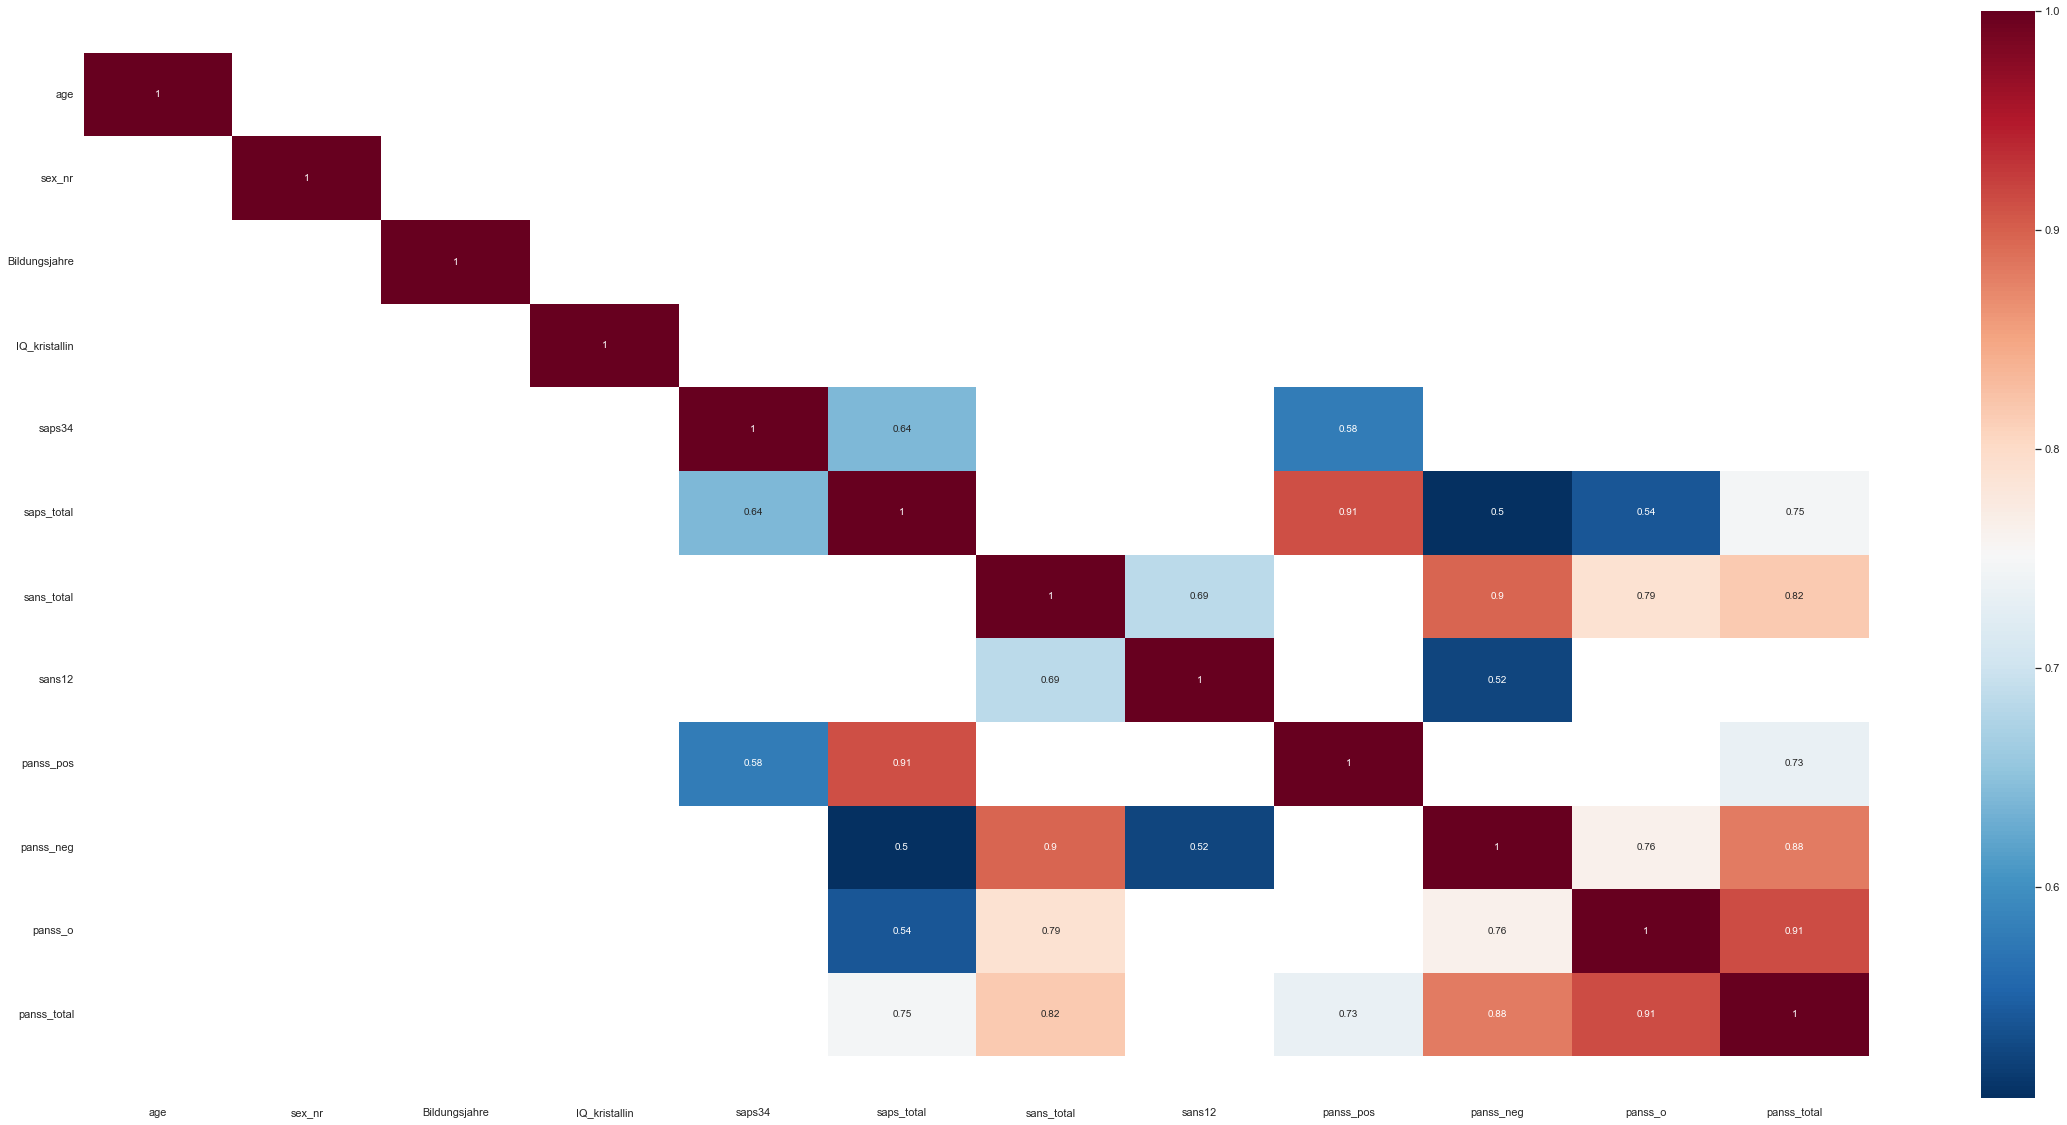

In [134]:
corr = show_corrtest_mask_corr(combined_data_averaged[cols])
## 1. age does not correlate with IQ, education years, or psychiatric scales
## 2. IQ does not correlate with education years or psychiatric scales
## 3. saps-total correlates with saps34 and panss_pos
## 4. sans-total correlates with sans12 and panss_neg, panss_o, panss_total
## 5. panss-total correlates with panss_o, panss_neg, sans-total, panss_pos, saps-total

In [135]:
num_scale_cols = ['saps34','saps_total', 'sans_total', 'sans12',
                  'panss_pos', 'panss_neg', 'panss_o', 'panss_total']

In [136]:
scale_cols = ['saps_total',
             'sans_total',
             'panss_pos',
             'panss_neg',
             'panss_o',
             'panss_total']

In [137]:
r = mean_std(combined_data_averaged, num_scale_cols)

In [138]:
r.loc['max'] = pd.Series([5, 170, 120, 5, 49, 49, 112, 210], index=r.columns)
r.loc['min'] = pd.Series([0, 0, 0, 0, 7, 7, 16, 30], index=r.columns)
r.loc['share'] = r.loc['value'].apply(lambda x: float(x.split(' ')[0])) / r.loc['max'] 

In [139]:
r

,saps34,saps_total,sans_total,sans12,panss_pos,panss_neg,panss_o,panss_total
value,1.03 (1.05),16.81 (16.7),27.73 (20.35),0.92 (1.19),12.66 (5.48),16.85 (6.03),27.75 (7.51),57.26 (16.18)
max,5,170,120,5,49,49,112,210
min,0,0,0,0,7,7,16,30
share,0.206,0.098882,0.231083,0.184,0.258367,0.343878,0.247768,0.272667


In [140]:
nap = combined_data_averaged[combined_data_averaged['group'] == 1]

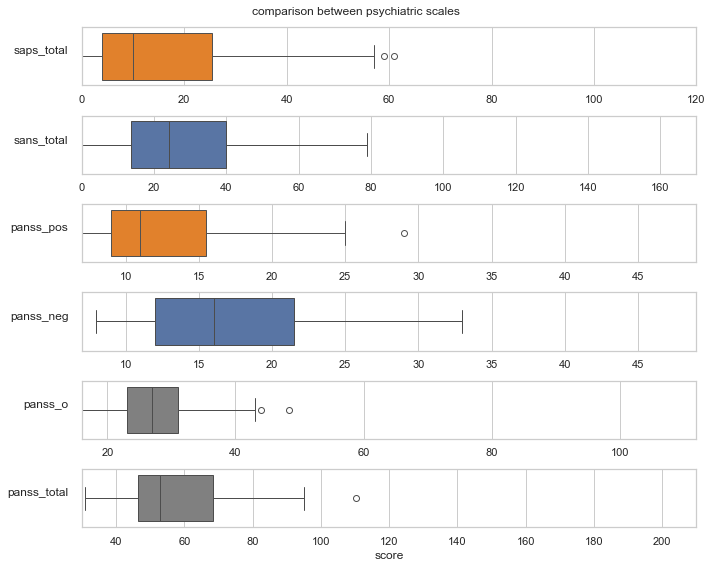

In [141]:
fig, axes = plt.subplots(6, 1, figsize=(10, 8))
fig.suptitle('comparison between psychiatric scales')
sns.boxplot(x=nap['saps_total'], ax=axes[0], color='tab:orange')
axes[0].set_xlim(0, 120)
axes[0].set_xlabel('')
axes[0].set_ylabel('saps_total', rotation='horizontal', ha='right')
sns.boxplot(x=nap['sans_total'], ax=axes[1])
axes[1].set_xlim(0, 170)
axes[1].set_xlabel('')
axes[1].set_ylabel('sans_total', rotation='horizontal', ha='right')
sns.boxplot(x=nap['panss_pos'], ax=axes[2], color='tab:orange')
axes[2].set_xlim(7, 49)
axes[2].set_xlabel('')
axes[2].set_ylabel('panss_pos', rotation='horizontal', ha='right')
sns.boxplot(x=nap['panss_neg'], ax=axes[3])
axes[3].set_xlim(7, 49)
axes[3].set_xlabel('')
axes[3].set_ylabel('panss_neg', rotation='horizontal', ha='right')
sns.boxplot(x=nap['panss_o'], ax=axes[4], color='grey')
axes[4].set_xlim(16, 112)
axes[4].set_xlabel('')
axes[4].set_ylabel('panss_o', rotation='horizontal', ha='right')
sns.boxplot(x=nap['panss_total'], ax=axes[5], color='grey')
axes[5].set_xlim(30, 210)
axes[5].set_xlabel('')
axes[5].set_ylabel('panss_total', rotation='horizontal', ha='right')
axes[5].set_xlabel('score')
fig.tight_layout();
plt.savefig(f'{PATH_FIG}psychiatric.png', dpi=150, bbox_inches = 'tight')

In [142]:
# corr = show_corrtest_mask_corr(combined_data_averaged[num_scale_cols])

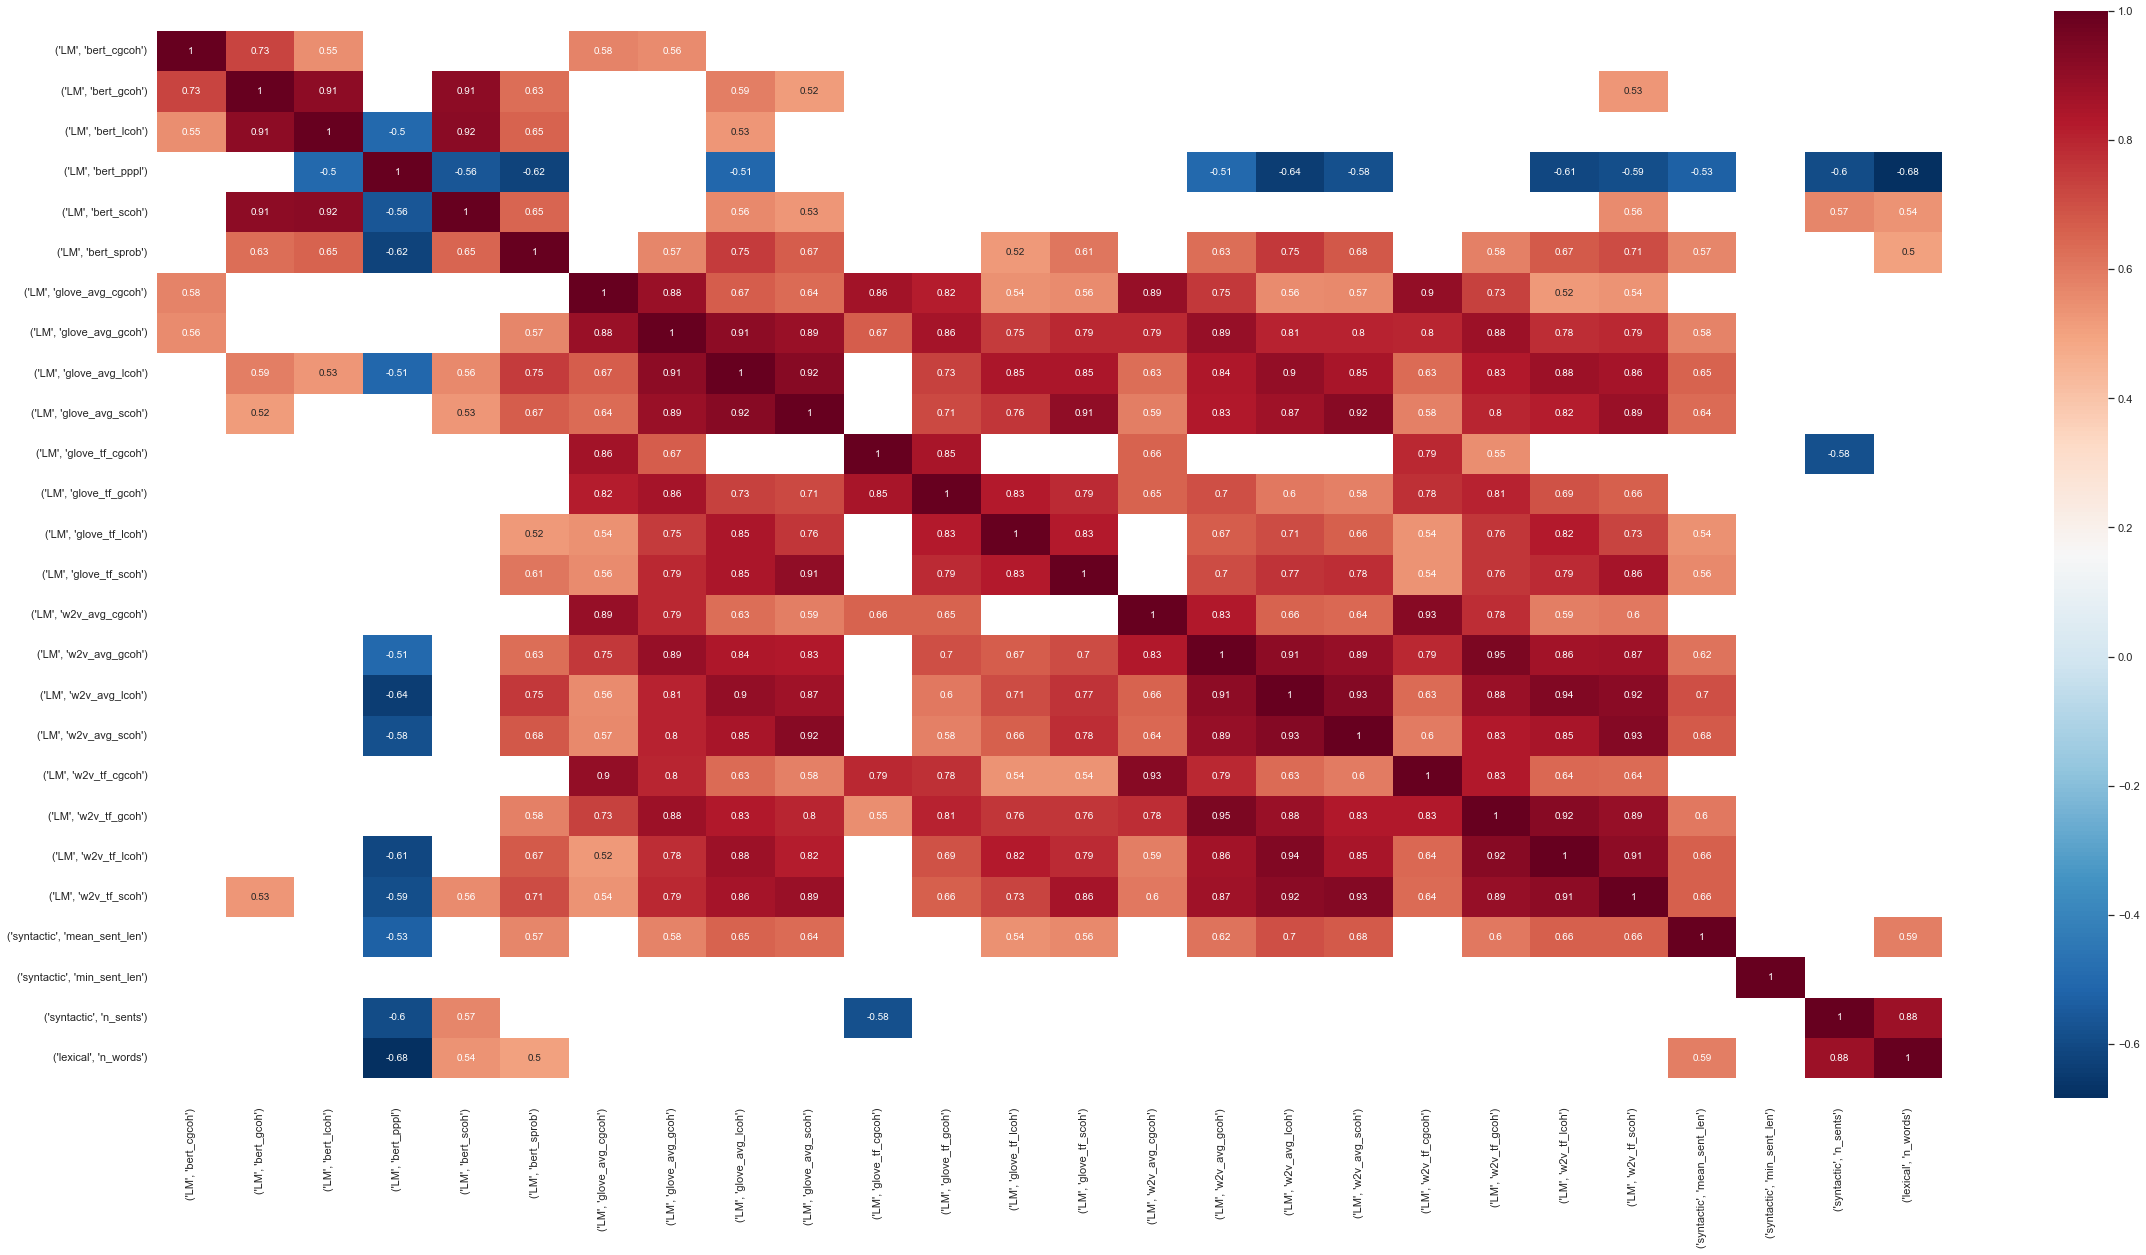

In [143]:
corr = show_corrtest_mask_corr(combined_data_averaged[cols_LM + [('syntactic', 'mean_sent_len'), ('syntactic', 'min_sent_len'), ('syntactic', 'n_sents'), ('lexical', 'n_words')]]);
## m_lcoh, m_gcoh, m_cgcoh, m_scoh;  m_raw_lcog, m_raw_scoh, m_raw_gcoh, m_raw_cgcoh - all but m_cgcoh
## m_sprob, m_bert_lcoh, m_bert_gcoh, m_bert_cgcoh, m_bert_scoh
## m_raw_cgcoh, m_raw_gcoh + m_bert_cgcoh ; m_raw_lcog, m_raw_scoh + m_bert_gcoh

## m_bert_scoh, m_sprob + n_words
## m_cgcoh - n_sents; m_bert_scoh + n_sents
## m_gcoh, m_lcoh, m_scoh (lcoh strongest);  m_raw - all but cgcoh (ccoh weakest); m_sprob - mean_sent_len

In [144]:
corr[abs(corr[('syntactic', 'mean_sent_len')]) > 0.5][('syntactic', 'mean_sent_len')]

(LM, bert_pppl)              -0.529038
(LM, bert_sprob)              0.570677
(LM, glove_avg_gcoh)          0.576522
(LM, glove_avg_lcoh)          0.654084
(LM, glove_avg_scoh)          0.637839
(LM, glove_tf_lcoh)           0.543768
(LM, glove_tf_scoh)           0.559634
(LM, w2v_avg_gcoh)            0.617361
(LM, w2v_avg_lcoh)            0.702037
(LM, w2v_avg_scoh)            0.676547
(LM, w2v_tf_gcoh)             0.602105
(LM, w2v_tf_lcoh)             0.662742
(LM, w2v_tf_scoh)             0.661627
(syntactic, mean_sent_len)    1.000000
(lexical, n_words)            0.590887
Name: (syntactic, mean_sent_len), dtype: float64

In [145]:
corr[abs(corr[('syntactic', 'n_sents')]) > 0.5][('syntactic', 'n_sents')]

(LM, bert_pppl)        -0.595283
(LM, bert_scoh)         0.570424
(LM, glove_tf_cgcoh)   -0.580744
(syntactic, n_sents)    1.000000
(lexical, n_words)      0.879802
Name: (syntactic, n_sents), dtype: float64

In [146]:
corr[abs(corr[('lexical', 'n_words')]) > 0.5][('lexical', 'n_words')]

(LM, bert_pppl)              -0.684196
(LM, bert_scoh)               0.535455
(LM, bert_sprob)              0.503740
(syntactic, mean_sent_len)    0.590887
(syntactic, n_sents)          0.879802
(lexical, n_words)            1.000000
Name: (lexical, n_words), dtype: float64

In [147]:
# corr = show_corrtest_mask_corr(combined_data_averaged[cols_synt])
## noun - det 0.62
## pron - noun -0.5
## sconj - min_sent_len 0.55
## mean - max sent_men 0.92
## max - std sent_len 0.96
## mean - std sent_len 0.94

In [148]:
# corr = show_corrtest_mask_corr(combined_data_averaged[cols_av])

In [149]:
s, t = display_test(combined_data_averaged, scale_cols + ['Bildungsjahre', 'age', 'IQ_kristallin'], ('syntactic', 'mean_sent_len'), stats.pearsonr, stat_name='r')
t['p'] = t['p'] * (len(t))
t['corr_sig'] = t['p'] < 0.05
t['p'] = t['p'] / (len(t))
t.drop(columns=['sig'], inplace=True)
t.sort_values([f'abs_r', 'p'], ascending=False)

,r,p,abs_r,corr_sig
sans_total,-0.443426,0.000436,0.443426,True
panss_neg,-0.423542,0.00083,0.423542,True
panss_total,-0.336072,0.009259,0.336072,False
panss_o,-0.28925,0.026286,0.28925,False
Bildungsjahre,0.288602,0.010393,0.288602,False
saps_total,-0.193752,0.141462,0.193752,False
IQ_kristallin,0.133302,0.318493,0.133302,False
panss_pos,-0.130267,0.325417,0.130267,False
age,0.069385,0.543447,0.069385,False


# Control for the effect of length

In [150]:
def plot_scatter_corr(x, y, x_name, y_name, ax, title=None, c=None, classes=('control', 'NAP')):
    r = stats.pearsonr(x, y).statistic
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    ypred = model.predict(X)
    ax.plot(x, ypred, color='red', label=f'coef: {model.params[1]:.2f} \ncorr: {r:.2f}')
    print(f'{x_name}, {y_name}, coef: {model.params[1]:.2f} \ncorr: {r:.2f}')

    if c is not None:
        cmap = ListedColormap(('steelblue', 'gold'))
        scatter = ax.scatter(x, y, c=c, cmap=cmap)
        ax.legend(handles=scatter.legend_elements()[0], labels=classes)
    else:
        scatter = ax.scatter(x, y)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)

In [151]:
for col in [('lexical', 'n_words'), ('syntactic', 'n_sents'), ('syntactic', 'mean_sent_len')]:
    print(col, f'{combined_data_averaged[col].mean().round(1)} ({combined_data_averaged[col].std().round(1)})')

('lexical', 'n_words') 184.2 (117.4)
('syntactic', 'n_sents') 17.9 (9.3)
('syntactic', 'mean_sent_len') 10.0 (2.8)


In [152]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
fig.suptitle('number of words against number of sentences and mean sentence length')
plot_scatter_corr(combined_data_averaged[('syntactic', 'n_sents')], combined_data_averaged[('lexical', 'n_words')],
                 x_name='n_sents', y_name='n_words', ax=axes[0], c=combined_data_averaged['group'])
plot_scatter_corr(combined_data_averaged[('syntactic', 'mean_sent_len')], combined_data_averaged[('lexical', 'n_words')],
                 x_name='mean_sent_len', y_name='n_words', ax=axes[1], c=combined_data_averaged['group'])
plt.savefig(f'{PATH_FIG}n_words_n_sents.png', dpi=150, bbox_inches = 'tight')
plt.close(fig)

n_sents, n_words, coef: 11.09 
corr: 0.88
mean_sent_len, n_words, coef: 24.88 
corr: 0.59


In [153]:
combined_data_averaged[combined_data_averaged[('lexical', 'n_words')] < 100][('lexical', 'n_words')]

ID
MPP_014    41.00
MPP_016    97.00
MPP_019    56.50
MPP_024    75.25
MPP_029    57.50
MPP_034    84.25
MPP_036    83.50
MPP_038    66.00
MPP_039    99.00
MPP_043    98.25
MPP_046    88.00
MPP_005    58.00
MPP_006    64.00
MPP_068    40.00
MPP_009    49.00
Name: (lexical, n_words), dtype: float64

In [154]:
compute_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'PRON'),
                                  column_names=['pronoun'], target_name='sans', add_sq=False)[0]

0.0067038537605466075

In [155]:
compute_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'),
                                  column_names=['sent len'], target_name='sans', add_sq=False)[0]

0.19662682046537683

In [156]:
compute_ortogonolized_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), 
                                  ('syntactic', 'PRON'),
                                  column_names=['sent len', 'punct'], target_name='sans', add_sq=False)[0]

0.0011661184394754498

In [157]:
compute_ortogonolized_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), 
                                  ('syntactic', 'min_sent_len'),
                                  column_names=['sent len', 'min sent len'], target_name='sans', add_sq=False)[0]

0.0069434380573168974

### bootstrap 

In [158]:
## 1 sample with replacement

## 1.1 compute_ortogonolized_r for each scale


In [159]:
t_test(combined_data_averaged, ('syntactic', 'mean_sent_len'), 'group', test=stats.ttest_ind, nan_policy='omit', stat_name='x', alpha=0.05)

5.988683527180032

In [160]:
scales = ["saps_total", "sans_total", "panss_total", "panss_pos", "panss_neg", "panss_o"]

def bootstrap(df, cols_av, scale_cols, N, col_to_correct_for=('syntactic', 'mean_sent_len'), group=None):
    dict_scales_sapmles = {k: {scale: {metric: [] for metric in cols_av} for scale in scale_cols} \
                           for k in ('sample_corr', 'sample_raw', 'r', 't', 'r_corr_w_control')}
    for i in tqdm(range(N)):
        sample = draw_sample_with_replacement(df, seed=i)
        for scale in scale_cols:
            for col in cols_av:
                if group:
                    t_test_res = t_test(sample, col, group)
                    dict_scales_sapmles['t'][scale][col].append(t_test_res)
                    
                r_raw = compute_coefficient(sample, scale, col)[0]
                dict_scales_sapmles['sample_raw'][scale][col].append(r_raw)
                
                droped = sample.dropna(subset=[col, scale])
                r = stats.pearsonr(droped[col], droped[scale])[0]
                dict_scales_sapmles['r'][scale][col].append(r)
                
                if col != col_to_correct_for:
                    
                    droped_c = sample.dropna(subset=[col, col_to_correct_for])
                    r_c = stats.pearsonr(droped_c[col], droped_c[col_to_correct_for])[0]
                    dict_scales_sapmles['r_corr_w_control'][scale][col].append(r_c)
                    r_corr = compute_ortogonolized_coefficient(sample, scale, col_to_correct_for, col)[0]
                    dict_scales_sapmles['sample_corr'][scale][col].append(r_corr)

    return dict_scales_sapmles

#### expensive to compute

In [161]:
# dict_scales_sapmles = bootstrap(combined_data_averaged, cols_av, scales, 1000, col_to_correct_for=('syntactic', 'mean_sent_len'), group='group')

In [162]:
# reform = {(scale, measure): dict_scales_sapmles[measure][scale] for scale in scale_cols for measure in dict_scales_sapmles}

In [163]:
# with open('de_scales_samples.pickle', 'wb') as f:
#     pickle.dump(reform, f)

In [164]:
with open('de_scales_samples.pickle', 'rb') as f:
    reform = pickle.load(f)

In [165]:
reformed_d = pd.DataFrame(reform)

In [166]:
reformed_d.index = pd.MultiIndex.from_tuples([(c[0], c[1].replace('sporb', 'sprob')) for c in reformed_d.index])

In [167]:
# reformed_d

In [168]:
# reformed_d[reformed_d['sans_total'].apply(lambda x: x['r_corr_w_control']==[], axis=1)]['saps_total','r_corr_w_control']

In [169]:
figprms = {'syntactic': 
               {'subplot_size': (9, 4.5),
                'wspace': 0.25,
                'hspace': 0.125,
                'yt': 0.925
                }, 
           'LM': 
               {'subplot_size': (9, 5.5),
                'wspace': 0.275,
                'hspace': 0.125,
                'yt': 0.92
               }, 
           'lexical': 
               {'subplot_size': (9, 2),
                'wspace': 0.2,
                'hspace': 0.25,
                'yt': 0.925
               }, 
           'graph': 
               {'subplot_size': (9, 3.5), 
                'wspace': 0.3,
                'hspace': 0.125,
                'yt': 0.925
               }}

In [170]:
def get_fparams(m_type, n_sublots_height, n_sublots_width, figparams):
    subplot_size = figprms[m_type]['subplot_size']
    width = subplot_size[0] * n_sublots_width
    height = subplot_size[1] * n_sublots_height
    figsize = (width, height)
    wspace = figprms[m_type]['wspace']
    hspace = figprms[m_type]['hspace']
    yt = figprms[m_type]['yt']
    return figsize, wspace, hspace, yt

In [171]:
ORDERED_SCALES = ['panss_pos', 'panss_neg', 'panss_o', 'panss_total', 'saps_total', 'sans_total']

In [172]:
def plot_horizontal_tasks(df, title, measure, m_type='syntactic', plot_abs=False, figparams=figprms):
    figsize, wspace, hspace, yt = get_fparams(m_type, 3, 2, figparams)
    fig, axes = plt.subplots(3, 2, figsize=figsize, sharex=True)
    fig.suptitle(title, y=yt+0.25)
    plt.subplots_adjust(wspace=wspace) #left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    
    ab = 'abs ' if plot_abs else ''
    
    axs = axes.flatten()

    for i, scale in enumerate(ORDERED_SCALES):
        ax = axs[i]
        d = prep_horizontal_pointplot_errobar_data(df[scale].loc[m_type], measure, plot_abs=plot_abs)
        pointplot_horizontal(d, x=measure, ax=ax)
        ax.set_title(f'{ab}{measure} {scale}')
    
    add_grey(axes)

    if plot_abs:
        for ax in axes.reshape(-1): 
            ax.set_xlabel('abs ' + measure);
    return fig

In [173]:
# m_type = 'syntactic'
# fig = plot_horizontal_tasks(reformed_d, title=f'cross-scale comparison for {m_type} metrics', 
#                             measure='r', m_type=m_type, plot_abs=False)

In [174]:
def plot_all(df, m_type='syntactic', measure='r', path=PATH_FIG, dpi=150, plot_abs=False, figparams=figprms):
    ab = 'abs_' if plot_abs else ''
    absolute_value = f' (absolute {measure} value)' if plot_abs else ''
    fig = plot_horizontal_tasks(df, title=f'cross-scale comparison for {m_type} metrics{absolute_value}', 
                                measure=measure, m_type=m_type, plot_abs=plot_abs, figparams=figprms)
    plt.savefig(f'{path}{m_type}/{ab}scale_r.png', dpi=dpi)
    plt.close(fig)
    
    figsize, wspace, hspace, yt = get_fparams(m_type, 1, 1, figparams)
    d_t = prep_horizontal_pointplot_errobar_data(df['panss_o'].loc[m_type], 't')
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle(f'group difference (t-test) for {m_type} metrics')
    pointplot_horizontal(d_t, 't', ax=ax)
    add_grey(ax, r=2)
    plt.savefig(f'{path}{m_type}/t.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    d_c = prep_horizontal_pointplot_errobar_data(df['panss_o'].loc[m_type], 'r_corr_w_control')
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle(f'correlation with mean sentence length for {m_type} metrics')
    pointplot_horizontal(d_c, 'r_corr_w_control', ax=ax)
    ax.set_xlabel('r');
    add_grey(ax)
    plt.savefig(f'{path}{m_type}/corr_len.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)

    figsize, wspace, hspace, yt = get_fparams(m_type, 1, 2, figparams)
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(f'group difference and correlation with mean sentence length for {m_type} metrics', y=yt+0.12)
    plt.subplots_adjust(wspace=wspace)
    pointplot_horizontal(d_t, x='t', ax=axes[0])
    axes[0].set_title('group difference (t-test)')
    pointplot_horizontal(d_c, x='r_corr_w_control', ax=axes[1])
    axes[1].set_title('correlation with mean sentence length')
    axes[1].set_xlabel('r');
    add_grey(axes[0], r=2)
    add_grey(axes[1])
    plt.savefig(f'{path}{m_type}/t_test_corr_len.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)

In [175]:
# m_type='lexical'
# plot_all(reformed_d, m_type, plot_abs=True)

In [176]:
for m_type in reformed_d.index.unique(level=0):
    plot_all(reformed_d, m_type, plot_abs=True)
    plot_all(reformed_d, m_type, plot_abs=False)

In [177]:
order=['bert', 'glove_tf', 'glove_avg', 'w2v_tf', 'w2v_avg']
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# fig.suptitle('corr sans')
# d = prep_LM_pointplot(reformed_d.loc['LM', 'sans_total'], 'r', plot_abs=True)
# pointplot(d, x='model', y='r', hue='metric', ax=ax, use_errorbar=True, order=order)
# add_grey(ax, line_dir='h')

In [178]:
def plot_LM_scales(df, title, measure='r', plot_abs=False, figsize=(18, 18), order=order):
    ab = 'abs ' if plot_abs else ''
    absolute_value = f' (absolute {measure} value)' if plot_abs else ''
    
    fig, axes = plt.subplots(3, 2, figsize=figsize, sharey=True)
    fig.suptitle(title + absolute_value, y=0.91)
    plt.subplots_adjust(wspace=0.075)
    
    axs = axes.flatten()
    for i, scale in enumerate(ORDERED_SCALES):
        ax = axs[i]
        d = prep_LM_pointplot(df.loc['LM', scale], measure, plot_abs=plot_abs)
        pointplot(d, x='model', y=measure, hue='metric', ax=ax, order=order, use_errorbar=True)
        ax.set_title(f'{ab}{measure} {scale}')
    
    add_grey(axes, line_dir='h')
    if plot_abs:
        for ax in axes.reshape(-1): 
            ax.set_ylabel('abs ' + measure);
    return fig

In [179]:
# fig = plot_LM_scales(reformed_d, 'corr', plot_abs=False)

In [180]:
def plot_all_LM(df, path=PATH_FIG, dpi=150, plot_abs=False, figsize=(9, 9), measure='r'):
    
    ab = 'abs_' if plot_abs else ''
    
    fig = plot_LM_scales(df, 'cross-scale comparison of LM metrcis across models', plot_abs=plot_abs)
    plt.savefig(f'{path}LM/model/{ab}scale_r.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    d_lm_t = prep_LM_pointplot(df.loc['LM', 'panss_o'], 't')
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle('group difference (t-test) for LM metrcis across models')
    pointplot(d_lm_t, x='model', y='t', hue='metric', ax=ax, order=order, use_errorbar=True)
    add_grey(ax, r=2, line_dir='h')
    plt.savefig(f'{path}LM/model/t.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    absolute_value = f' (absolute {measure} value)' if plot_abs else ''
    d_lm_c = prep_LM_pointplot(df.loc['LM', 'panss_o'], 'r_corr_w_control', plot_abs=plot_abs)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle('correlation with mean sentence length for LM metrcis across models' + absolute_value)
    pointplot(d_lm_c, x='model', y='r_corr_w_control', hue='metric', ax=ax, order=order, use_errorbar=True)
    ax.set_xlabel(f'{ab}r')
    add_grey(ax, line_dir='h')
    plt.savefig(f'{path}LM/model/{ab}corr_len.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('group difference and correlation with mean sentence length of LM metrcis across models')

    pointplot(d_lm_t, x='model', y='t', hue='metric', ax=axes[0], order=order, use_errorbar=True)
    axes[0].set_title('group difference (t-test)')

    pointplot(d_lm_c, x='model', y='r_corr_w_control', hue='metric', ax=axes[1], order=order, use_errorbar=True)
    axes[1].set_title('correlation with mean sentence length')
    axes[1].set_xlabel('r')
    add_grey(axes[0], r=2, line_dir='h')
    add_grey(axes[1], line_dir='h')
    plt.savefig(f'{path}LM/model/t_test_corr_len.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)

In [181]:
plot_all_LM(reformed_d, plot_abs=True)
plot_all_LM(reformed_d, plot_abs=False)

### cross-metric comparison

In [182]:
scales_ = ('saps_total', 'sans_total', 'panss_pos', 'panss_neg', 'panss_o', 'panss_total')

In [183]:
def select_ok_metrics(row, t=1, r=0.3, rc=0.3):
    ok_corr = False
    ok_t = abs(row['saps_total', 't']) >= t
    ok_len = pd.isna(row['saps_total', 'r_corr_w_control']) or abs(row['saps_total', 'r_corr_w_control']) <= rc
    for scale in scales_:
        if abs(row[scale, 'r']) >= r:
            ok_corr = True 
            break
    return (ok_corr or ok_t) and ok_len

In [184]:
def select_ok_metrics_for_one_scale(row, scale, r=0.3, rc=0.3):
    ok_corr = False
    ok_len = pd.isna(row['panss_total', 'r_corr_w_control']) or abs(row['panss_total', 'r_corr_w_control']) <= rc
    ok_corr = abs(row[scale, 'r']) >= r
    return ok_corr and ok_len

In [185]:
def select_control_corr_ms_better_than_len(row, row_len, r=0.3, rc=0.3):
    if select_ok_metrics(row, r=r, rc=rc):
        return False
    ok_len = pd.isna(row['saps_total', 'r_corr_w_control']) or abs(row['saps_total', 'r_corr_w_control']) <= rc
    if ok_len:
        return False
    else:
        for scale in scales_:
            if abs(row[scale, 'r']) >= abs(row_len[scale, 'r']):
                return True
        return False

In [186]:
def select_control_corr_ms_better_than_len_for_one_scale(row, row_len, scale, r=0.3, rc=0.3):
    if select_ok_metrics(row, r=r, rc=rc):
        return False
    ok_len = pd.isna(row['saps_total', 'r_corr_w_control']) or abs(row['saps_total', 'r_corr_w_control']) <= rc
    if ok_len:
        return False
    else:
        if abs(row[scale, 'r']) >= abs(row_len[scale, 'r']) and abs(row[scale, 'r']) > r:
            return True
        return False

In [187]:
def select_bad_len_metrics(row, rc=0.3):
    ok_len = pd.isna(row['panss_total', 'r_corr_w_control']) or abs(row['panss_total', 'r_corr_w_control']) <= rc
    return not ok_len

In [188]:
median_d = reformed_d.applymap(np.nanmedian)

In [189]:
idxs_scale = {}
idxs_bad_bet_len = {}
for scale in scales_:
    ids = median_d[median_d.apply(lambda x: select_ok_metrics_for_one_scale(x, scale=scale), axis=1)].index
    idxs_scale[scale] = ids
    idsl = median_d[median_d.apply(lambda x: select_control_corr_ms_better_than_len_for_one_scale(x, 
                                                                                                  row_len=median_d.loc[('syntactic', 'mean_sent_len')], 
                                                                                                  scale=scale), axis=1)].index
    idxs_bad_bet_len[scale] = idsl

In [190]:
good_ms = sorted(list(set([y for x in idxs_scale.values() for y in x])))

In [191]:
bad_ms_better_than_len = sorted(list(set([y for x in idxs_bad_bet_len.values() for y in x])))

In [192]:
bad_ms = median_d[median_d.apply(select_bad_len_metrics, axis=1)].index

In [193]:
# bad_ms_better_than_len = median_d[median_d.apply(lambda row: select_control_corr_ms_better_than_len(row, median_d.loc[('syntactic', 'mean_sent_len')]), axis=1)].index

In [194]:
set(bad_ms_better_than_len).issubset(set(bad_ms))

True

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
fig.suptitle('cross-type metric comparison for correlation with mean sent len')
measure = 'r_corr_w_control'
plot_abs = False


d = prep_horizontal_pointplot_errobar_data(reformed_d['panss_pos'].loc[bad_ms], measure, plot_abs=plot_abs)
pointplot_horizontal(d, x=measure, ax=ax)
ax.set_xlabel('r')
add_grey(ax)
plt.savefig(f'{PATH_FIG}/compare_corr_len.png', dpi=150, bbox_inches = 'tight')
plt.close(fig)

In [196]:
# idx_comp_r = median_d[median_d.apply(lambda x: select_ok_metrics(x, t=3), axis=1)].index

In [197]:
ms_to_plot = sorted(bad_ms_better_than_len+ good_ms)

In [198]:
len(ms_to_plot)

21

In [199]:
len(good_ms)

4

In [200]:
{s: len(idxs_scale[s]) + len(idxs_bad_bet_len[s]) for s in idxs_scale}

{'saps_total': 5,
 'sans_total': 10,
 'panss_pos': 1,
 'panss_neg': 12,
 'panss_o': 14,
 'panss_total': 16}

In [201]:
{s: len(idxs_scale[s]) for s in idxs_scale}

{'saps_total': 1,
 'sans_total': 3,
 'panss_pos': 0,
 'panss_neg': 3,
 'panss_o': 2,
 'panss_total': 3}

In [202]:
def sort_index(idxs):
    ms = sorted(idxs)
    for s in ('syntactic: mean_sent_len', 'mean_sent_len', ('syntactic', 'mean_sent_len')):
        if s in ms:
            ms.remove(s)
            ms.append(s)
    return ms 

In [203]:
def map_marker(m, scale, idxs_scale): #, idxs_bad_bet_len
    if m in idxs_scale[scale]:
        return 'o'
#     elif m in idxs_bad_bet_len[scale]:
#         return 'v'
    else: 
        return 'x'

In [204]:
def add_len_lines(ax, median_d, scale):
    ax.axvline(median_d.loc[('syntactic', 'mean_sent_len')][scale, 'r'], linestyle='--')
    ax.axvline(-median_d.loc[('syntactic', 'mean_sent_len')][scale, 'r'], linestyle='--')

In [205]:
def plot_one_scale(ax, scale, idxs_scale, reformed_d, ms_to_plot, measure, plot_abs):
    markers = [map_marker(m, scale, idxs_scale) for m in ms_to_plot]
    if ('syntactic', 'mean_sent_len') in idxs_scale[scale]:
        add_len_lines(ax, median_d, scale)
    d = prep_horizontal_pointplot_errobar_data(reformed_d[scale].loc[ms_to_plot], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=ax, markers=markers)
    ax.set_title(f'{measure} {scale}')

In [206]:
fig, axes = plt.subplots(3, 2, figsize=(18, 14), sharex=True)
fig.suptitle('cross-scale cross-type metric comparison', y=0.915)
plt.subplots_adjust(wspace=0.4, hspace=0.1) #left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
measure = 'r'
plot_abs = False
idxs = sort_index(ms_to_plot)
axs = axes.flatten()

for i, scale in enumerate(ORDERED_SCALES):
    ax = axs[i]
    plot_one_scale(ax, scale, idxs_scale, reformed_d, ms_to_plot, measure, plot_abs)
    
add_grey(axes)
plt.savefig(f'{PATH_FIG}/compare_r.png', dpi=150, bbox_inches = 'tight')
plt.close(fig)

In [207]:
def select_ok_metrics_t(row):
    q25 = np.quantile(row['saps_total', 't'], 0.25)
    q75 = np.quantile(row['saps_total', 't'], 0.75)
    return q25 > 0 or q75 < 0

In [208]:
idx_comp_t = reformed_d[reformed_d.apply(select_ok_metrics_t, axis=1)].index

In [209]:
idx_comp_t

MultiIndex([('syntactic',             'ADV'),
            ('syntactic',           'SCONJ'),
            ('syntactic',    'max_sent_len'),
            ('syntactic',   'mean_sent_len'),
            ('syntactic',    'std_sent_len'),
            (       'LM',       'bert_pppl'),
            (  'lexical',             'LTR'),
            (  'lexical',         'n_words'),
            (    'graph',             'LCC'),
            (    'graph',             'LSC'),
            (    'graph', 'number_of_edges'),
            (    'graph', 'number_of_nodes')],
           )

In [210]:
fig, axes = plt.subplots(1, 2, figsize=(18, 4))
plt.subplots_adjust(wspace=0.4)
fig.suptitle('cross-type metric comparison for group difference and correlation with mean sentence length', y=1)

dcr = reformed_d['sans_total'].loc[idx_comp_t].drop([('syntactic', 'mean_sent_len')])
d_c = prep_horizontal_pointplot_errobar_data(dcr, 'r_corr_w_control', plot_abs=False)
d_t = prep_horizontal_pointplot_errobar_data(reformed_d['sans_total'].loc[idx_comp_t], 't', plot_abs=False)


pointplot_horizontal(d_t, x='t', ax=axes[0])
axes[0].set_title('t')
axes[0].set_title('group difference (t-test)')

pointplot_horizontal(d_c, x='r_corr_w_control', ax=axes[1])
axes[1].set_title('correlation with mean sentence length')
axes[1].set_xlabel('r');
add_grey(axes[0], r=2)
add_grey(axes[1])
plt.savefig(f'{PATH_FIG}/compare_t.png', dpi=150, bbox_inches = 'tight')
plt.close(fig)

In [211]:
scales_ = ('sans_total', 'saps_total', 'panss_pos', 'panss_neg', 'panss_o', 'panss_total')
sc_ind_ = ('t', 'r_corr_w_control')
models_ = ('bert', 'glove_tf', 'glove_avg', 'w2v_tf', 'w2v_avg')
metrics_ = ('cgcoh', 'gcoh', 'lcoh', 'scoh', 'sprob', 'pppl')

In [282]:
def mean_model_metric_medians(median_df, leave_out=()):
    resp_d_model = pd.DataFrame(columns=[f'{sc} abs r' for sc in scales_] + list(sc_ind_), index=models_)
    resp_d_metric = pd.DataFrame(columns=[f'{sc} abs r' for sc in scales_] + list(sc_ind_), index=metrics_)
    for scale in scales_:
        ex_d = prep_LM_pointplot(median_df.loc['LM', scale], col='r', use_errorbar=False, plot_abs=True)
        for model in models_:
            leave_out_ = ex_d[ex_d['model'] == model]
            leave_out_ = leave_out_[~leave_out_['metric'].isin(leave_out)]
            resp_d_model.loc[model, f'{scale} abs r'] = np.nanmean(leave_out_['r'])
        for metric in metrics_:
            resp_d_metric.loc[metric, f'{scale} abs r'] = np.nanmean(ex_d[ex_d['metric'] == metric]['r'])
    for sc_ind in sc_ind_:
        for model in models_:
            leave_out_ = ex_d[ex_d['model'] == model]
            leave_out_ = leave_out_[~leave_out_['metric'].isin(leave_out)]
            resp_d_model.loc[model, sc_ind] = np.nanmean(leave_out_[sc_ind])
        for metric in metrics_:
            resp_d_metric.loc[metric, sc_ind] = np.nanmean(ex_d[ex_d['metric'] == metric][sc_ind])
    return resp_d_model, resp_d_metric


In [290]:
resp_d_model, resp_d_metric = mean_model_metric_medians(median_d, leave_out=('pppl', 'sprob'))

In [284]:
style(resp_d_model)

,sans_total abs r,saps_total abs r,panss_pos abs r,panss_neg abs r,panss_o abs r,panss_total abs r,t,r_corr_w_control
bert,0.236577,0.044458,0.070800,0.225945,0.252583,0.226462,0.514233,0.164279
glove_tf,0.165831,0.208415,0.234428,0.192332,0.163716,0.198474,0.393175,0.423349
glove_avg,0.223965,0.196178,0.201043,0.234299,0.184733,0.232106,0.395287,0.559389
w2v_tf,0.280326,0.303823,0.259068,0.312226,0.254846,0.324987,0.729716,0.588787
w2v_avg,0.306191,0.246191,0.189937,0.314721,0.233608,0.291606,0.615956,0.612061


In [291]:
resp_d_model[['sans_total abs r',
 'saps_total abs r',
 'panss_pos abs r',
 'panss_neg abs r',
 'panss_o abs r',
 'panss_total abs r']].mean(axis=1).sort_values() 

bert         0.176137
glove_tf     0.193866
glove_avg    0.212054
w2v_avg      0.263709
w2v_tf       0.289213
dtype: float64

In [289]:
resp_d_model, resp_d_metric = mean_model_metric_medians(median_d)
resp_d_model[['sans_total abs r',
 'saps_total abs r',
 'panss_pos abs r',
 'panss_neg abs r',
 'panss_o abs r',
 'panss_total abs r']].mean(axis=1).sort_values() 

glove_tf     0.193866
glove_avg    0.212054
bert         0.215694
w2v_avg      0.263709
w2v_tf       0.289213
dtype: float64

In [293]:
resp_d_model['r_corr_w_control']

bert         0.164279
glove_tf     0.423349
glove_avg    0.559389
w2v_tf       0.588787
w2v_avg      0.612061
Name: r_corr_w_control, dtype: object

In [215]:
style(resp_d_metric)

,sans_total abs r,saps_total abs r,panss_pos abs r,panss_neg abs r,panss_o abs r,panss_total abs r,t,r_corr_w_control
cgcoh,0.105299,0.190543,0.142615,0.101842,0.085081,0.098206,0.878644,0.284133
gcoh,0.176844,0.182994,0.163320,0.200654,0.159135,0.204929,0.134453,0.489777
lcoh,0.314215,0.232792,0.256959,0.328474,0.292727,0.344978,0.730074,0.549403
scoh,0.373954,0.192923,0.201327,0.392648,0.334646,0.370794,0.375524,0.554980
sprob,0.246057,0.131360,0.202997,0.318323,0.278572,0.314921,1.287450,0.578790
pppl,0.471239,0.155317,0.119219,0.454768,0.432778,0.412121,2.038195,0.536772


In [292]:
resp_d_metric['r_corr_w_control']

cgcoh    0.284133
gcoh     0.489777
lcoh     0.549403
scoh      0.55498
sprob     0.57879
pppl     0.536772
Name: r_corr_w_control, dtype: object

In [287]:
resp_d_metric[['sans_total abs r',
 'saps_total abs r',
 'panss_pos abs r',
 'panss_neg abs r',
 'panss_o abs r',
 'panss_total abs r']].mean(axis=1).sort_values() 

cgcoh    0.120598
gcoh     0.181313
sprob    0.248705
lcoh     0.295024
scoh     0.311049
pppl     0.340907
dtype: float64

In [216]:
# idx_comp_t = median_d[median_d.apply(lambda x: select_ok_metrics(x, t=1, r=0.5), axis=1)].index
# fig, ax = plt.subplots(1, 1, figsize=(12, 5))
# fig.suptitle('t compare')
# d_t = prep_synt_pointplot_errobar_data(reformed_d['sans_total'].loc[idx_comp_t], 't', plot_abs=False)
# pointplot_synt(d_t, x='t', ax=ax)
# plt.xticks(np.arange(-2, 7, step=1));
# plt.savefig(f'{PATH_FIG}/compare_t.png', dpi=150, bbox_inches = 'tight')

In [217]:
# median_d[median_d.apply(select_ok_metrics, axis=1)]

In [220]:
sample_df = pd.DataFrame()
for scale in scale_cols:
    scale_metric_sd = {}
    scale_metric_md = {}
    scale_metric_mn = {}
    scale_metric_cov = {}
    scale_metric_diff = {}
    scale_metric_q25 = {}
    scale_metric_q75 = {}
    for col in cols_av:
        if col != ('syntactic', 'mean_sent_len'):
#             col_old = (col[0], col[1].replace('sprob', 'sprob'))
            sample = reform[(scale, 'sample_corr')][col]
            scale_metric_sd[col] = np.std(sample)
            scale_metric_md[col] = np.median(sample)
            scale_metric_mn[col] = np.mean(sample)
            scale_metric_q25[col] = np.quantile(sample, 0.25)
            scale_metric_q75[col] = np.quantile(sample, 0.75)
            scale_metric_cov[col] = np.std(sample) / np.mean(sample)
            scale_metric_diff[col] = np.mean(sample) / np.mean(reform[(scale, 'sample_raw')][col])
            
    sample_df[(scale, 'md')] = pd.Series(scale_metric_md)
    sample_df[(scale, 'mn')] = pd.Series(scale_metric_mn)
    sample_df[(scale, 'sd')] = pd.Series(scale_metric_sd)
    sample_df[(scale, 'cov')] = pd.Series(scale_metric_cov)
    sample_df[(scale, 'dif')] = pd.Series(scale_metric_diff)
    sample_df[(scale, 'q25')] = pd.Series(scale_metric_q25)
    sample_df[(scale, 'q75')] = pd.Series(scale_metric_q75)

In [221]:
# sample_df

In [222]:
sample_df.columns = pd.MultiIndex.from_tuples(sample_df.columns, names=('scale', 'res'))

In [223]:
ex_df = sample_df.loc['LM', 'sans_total'].drop(index='bert_sprob')
ex_df['model'] = [map_model(m) for m in ex_df.index]
ex_df['metric'] = [x.split('_')[-1] for x in ex_df.index]
# ex_df

In [224]:
# sns.set_theme(style="whitegrid")

# # Draw a pointplot to show pulse as a function of three categorical factors
# g = sns.catplot(
#     data=ex_df, x="model", y="md", hue="metric", order=['bert', 'w2v_raw', 'w2v'],
#     capsize=.2,  # errorbar="se",
#     kind="point", height=6, aspect=.75,
# )
# g.despine(left=True)

In [225]:
sample_df.columns = pd.MultiIndex.from_tuples(sample_df.columns, names=('scale', 'res'))
styler = pd.io.formats.style.Styler(sample_df, precision = 4)
# styler.background_gradient(axis=0, cmap='Reds')

In [227]:
# sns.histplot(dict_scales_sapmles['sample_corr']['sans_total'][('syntactic', 'AUX')], bins=30);

In [228]:
# sns.histplot(dict_scales_sapmles['sample_corr']['sans_total'][('LM', 'm_cgcoh')], bins=30);

In [229]:
# sns.histplot(dict_scales_sapmles['sample_corr']['sans_total'][('LM', 'm_bert_cgcoh')], bins=30);

### original

In [230]:
# plt.scatter(combined_data_averaged[('syntactic', 'mean_sent_len')], combined_data_averaged[('syntactic', 'AUX')]);

In [231]:
# ex_df = combined_data_averaged[combined_data_averaged[('syntactic', 'mean_sent_len')] > 5]
# draw_corrected_scatter(ex_df, 'sans_total', ('syntactic', 'mean_sent_len'), ('syntactic', 'AUX'),
#                       column_names=['sent len', 'punct'], target_name='sans')

In [232]:
compute_ortogonolized_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('syntactic', 'AUX'),
                                  column_names=['sent len', 'punct'], target_name='sans', add_sq=False)[0]

0.004861777549361124

In [233]:
compute_ortogonolized_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('LM', 'w2v_tf_cgcoh'),
                                  column_names=['sent len', 'punct'], target_name='sans', add_sq=False)[0]

0.02558778907996051

In [234]:
# draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('LM', 'w2v_tf_cgcoh'),
#                       column_names=['sent len', 'm_cgcoh'], target_name='sans')

In [235]:
# draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('syntactic', 'NOUN'),
#                       column_names=['sent len', 'num'], target_name='sans')

In [236]:
# draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('graph', 'number_of_edges'),
#                       column_names=['sent len', 'NE'], target_name='sans')

In [237]:
# draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('graph', 'number_of_nodes'),
#                       column_names=['sent len', 'NN'], target_name='sans')

In [238]:
# draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('lexical', 'MALTR'),
#                       column_names=['sent len', 'maltr'], target_name='sans')

In [239]:
# draw_corrected_scatter(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), ('LM', 'w2v_tf_cgcoh'),
#                       column_names=['sent len', 'm_cgcoh'], target_name='sans')

In [240]:
cols_dict = {}
for col in cols_av:
    cols_dict[col] = compute_ortogonolized_coefficient(combined_data_averaged, 'sans_total', ('syntactic', 'mean_sent_len'), col)[0]
combined_corr.insert(1, ('sans_total', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [241]:
cols_dict = {}
for col in cols_av:
    cols_dict[col] = compute_ortogonolized_coefficient(combined_data_averaged, 'saps_total', ('syntactic', 'mean_sent_len'), col)[0]
combined_corr.insert(1, ('saps_total', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [242]:
cols_dict = {}
for col in cols_av:
    cols_dict[col] = compute_ortogonolized_coefficient(combined_data_averaged, 'panss_total', ('syntactic', 'mean_sent_len'), col)[0]
combined_corr.insert(1, ('panss', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

In [243]:
cols_dict = {}
for col in cols_av:
    cols_dict[col] = compute_ortogonolized_logit(combined_data_averaged, 'group', ('syntactic', 'mean_sent_len'), col)
combined_corr.insert(1, ('t_test', 'r_corrected_for_mean_len'), pd.Series(cols_dict)) 

/Users/galina.ryazanskaya/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [244]:
t_p_n_corr_rank = pd.concat([combined_corr[('t_test', 'abs_t')].rank(ascending=False)] + [combined_corr[(scale, 'r_corrected_for_mean_len')].rank(ascending=False) for scale in ['sans_total', 'saps_total']], axis=1).mean(axis=1)
combined_corr.insert(1, ('mean', 'tpn_rank_corr'), t_p_n_corr_rank) 
combined_corr.insert(2, ('mean', 'tpn_rank_corr_abs'), t_p_n_corr_rank.rank()) 

In [245]:
# combined_corr.sort_values(('mean', 'tpn_rank_corr'), ascending=True).apply(pd.to_numeric).style.background_gradient(axis=0, cmap='Reds')

In [246]:
def get_ranking_difference(df, col_initial, col_final):
    return df[col_final].rank() - df[col_initial].rank()

In [247]:
rank_diff = pd.DataFrame()
rank_diff[('panss', 'rank_change')] = get_ranking_difference(combined_corr, ('panss', 'abs_r'), ('panss', 'r_corrected_for_mean_len'))
rank_diff[('panss', 'corrected_rank')] = combined_corr[('panss', 'r_corrected_for_mean_len')].rank()
rank_diff[('panss', 'corrected_r')] = combined_corr[('panss', 'r_corrected_for_mean_len')]


rank_diff[('sans', 'rank_change')] = get_ranking_difference(combined_corr, ('sans_total', 'abs_r'), ('sans_total', 'r_corrected_for_mean_len'))
rank_diff[('sans', 'corrected_rank')] = combined_corr[('sans_total', 'r_corrected_for_mean_len')].rank()
rank_diff[('sans', 'corrected_r')] = combined_corr[('sans_total', 'r_corrected_for_mean_len')]

rank_diff[('saps', 'rank_change')] = get_ranking_difference(combined_corr, ('saps_total', 'abs_r'), ('saps_total', 'r_corrected_for_mean_len'))
rank_diff[('saps', 'corrected_rank')] = combined_corr[('saps_total', 'r_corrected_for_mean_len')].rank()
rank_diff[('saps', 'corrected_r')] = combined_corr[('saps_total', 'r_corrected_for_mean_len')]

rank_diff[('t_test', 'rank_change')] = get_ranking_difference(combined_corr, ('t_test', 'abs_t'), ('t_test', 'r_corrected_for_mean_len'))
rank_diff[('t_test', 'corrected_rank')] = combined_corr[('t_test', 'r_corrected_for_mean_len')].rank()
rank_diff[('t_test', 'corrected_r')] = combined_corr[('t_test', 'r_corrected_for_mean_len')]
rank_diff[('t_test', 'val')] = combined_corr[('t_test', 'abs_t')]

rank_diff.columns = pd.MultiIndex.from_tuples(rank_diff.columns, names=('scale', 'res'))
rank_diff = rank_diff.apply(pd.to_numeric)

In [248]:
# rank_diff.style.background_gradient(axis=0, cmap='Reds')

In [249]:
n = [label[1] for label in rank_diff.index]
c_map = {'LM': 0, 'graph': 1, 'lexical': 2, 'syntactic': 3}
c = [c_map[label[0]] for label in rank_diff.index]

In [250]:
def plot_res_corr(x, y, n, x_name, y_name, title, c=None):
    r = stats.pearsonr(x, y).statistic
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    ypred = model.predict(X)
    plt.plot(x, ypred, color='red', label=f'coef: {model.params[1]:.2f} \ncorr: {r:.2f}')

    plt.gca().add_artist(plt.legend(loc=9))

    scatter_annotate(x, y, n, x_name, y_name, title, c=c)

In [251]:
plt.rcParams["figure.figsize"] = (15,8)

In [252]:
x = rank_diff[('panss', 'corrected_r')]
y = rank_diff[('t_test', 'corrected_r')]

plot_res_corr(x, y, n, 'panss r', 'ttest pseudo r', 'PANSS / TTEST', c)
plt.close()

In [253]:
x = rank_diff[('sans', 'corrected_r')]
y = rank_diff[('t_test', 'corrected_r')]

plot_res_corr(x, y, n, 'sans r', 'ttest pseudo r', 'SANS / TTEST', c)
plt.close()

In [254]:
x = rank_diff[('saps', 'corrected_r')]
y = rank_diff[('t_test', 'corrected_r')]

plot_res_corr(x, y, n, 'saps r', 'ttest pseudo r', 'SAPS / TTEST', c)
plt.close()

In [255]:
x = rank_diff[('saps', 'corrected_r')]
y = rank_diff[('panss', 'corrected_r')]

plot_res_corr(x, y, n, 'saps r', 'panss r', 'SAPS / PANSS', c)
plt.close()

In [256]:
x = rank_diff[('sans', 'corrected_r')]
y = rank_diff[('saps', 'corrected_r')]

plot_res_corr(x, y, n, 'sans r', 'saps r', 'SANS / SAPS', c)
plt.close()

In [257]:
x = rank_diff[('sans', 'corrected_r')]
y = rank_diff[('panss', 'corrected_r')]

plot_res_corr(x, y, n, 'sans r', 'panss r', 'SANS / PANSS', c)
plt.close()

In [258]:
x = rank_diff[('sans', 'corrected_rank')]
y = rank_diff[('panss', 'corrected_rank')]

plot_res_corr(x, y, n, 'sans rank', 'panss rank', 'SANS / PANSS', c)
plt.close()